In [1]:
# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import svm
from sklearn import tree
from sklearn.tree import _tree
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import explained_variance_score

# Importing and Creating Training & Testing Sets


In [4]:
original_train = pd.read_csv('../train.csv',header = 0)
original_train['dataset'] = 'train'
print original_train.shape

(10886, 13)


In [5]:
original_test = pd.read_csv('../test.csv',header = 0)
original_test['dataset'] = 'test'
print original_test.shape

(6493, 10)


In [6]:
df_complete =  original_train.copy().append(original_test.copy())
df_complete = df_complete.drop(['count'], axis = 1)

In [7]:
#add the counts as logarithms
df_complete['log_casual'] = df_complete['casual'].apply(np.log1p)
df_complete['log_registered'] = df_complete['registered'].apply(np.log1p)

In [8]:
# Make the datetime the index
df_complete['datetime'] = pd.to_datetime(df_complete['datetime'])

df_complete.index = df_complete['datetime']
del df_complete['datetime']


In [9]:
# Make sure we have all the complete values of the series
idx = pd.date_range('2011-01-01 00:00:00', '2012-12-31 23:00:00', freq='H')
df_complete = df_complete.reindex(idx)

In [10]:
#Put the target variables at the beggining
df_complete = df_complete[[u'casual', u'registered', u'log_casual', u'log_registered', u'dataset',  
       u'atemp', u'humidity', u'temp', u'windspeed', u'weather', u'season', u'workingday', u'holiday']]

In [11]:
# Missing entries? let's try to interpolate to get that info
missing = df_complete[pd.isnull(df_complete['atemp'])]
missing.shape

(165, 13)

In [11]:
df_complete["weather"] = df_complete["weather"].interpolate(method='time').apply(np.round)
df_complete["temp"] = df_complete["temp"].interpolate(method='time')
df_complete["atemp"] = df_complete["atemp"].interpolate(method='time')
df_complete["humidity"] = df_complete["humidity"].interpolate(method='time').apply(np.round)
df_complete["windspeed"] = df_complete["windspeed"].interpolate(method='time')
df_complete["season"] = df_complete["season"].interpolate(method='time').apply(np.round)
df_complete["workingday"] = df_complete["workingday"].interpolate(method='time').apply(np.round)
df_complete["holiday"] = df_complete["holiday"].interpolate(method='time').apply(np.round)

In [12]:
missing2 = df_complete[pd.isnull(df_complete['atemp'])]
missing2.shape

(165, 13)

In [13]:
df_complete.loc[missing.index].head()

,casual,registered,log_casual,log_registered,dataset,atemp,humidity,temp,windspeed,weather,season,workingday,holiday
2011-01-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_complete['month'] = df_complete.index.month
#df_complete['dayOfMonth'] = df_complete.index.day
df_complete['day'] = df_complete.index.dayofweek
df_complete['week'] = df_complete.index.week
df_complete['hour'] = df_complete.index.hour
df_complete['year'] = df_complete.index.year


In [15]:
df_complete['weekend'] = ((df_complete.index.dayofweek == 5) | (df_complete.index.dayofweek == 6)).astype(int)


In [16]:
df_complete["nat_dis"] = 0

# Initial Data View

In [ ]:
df_complete[df_complete['dataset']=='test'].head(2)

In [18]:
df_complete[df_complete['dataset'] == 'train'].describe()

,casual,registered,log_casual,log_registered,atemp,humidity,temp,windspeed,weather,season,workingday,holiday,month,day,week,hour,year,weekend,nat_dis
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0
mean,36.021955,155.552177,2.712439,4.395774,23.655084,61.886460,20.23086,12.799395,1.418427,2.506614,0.680875,0.028569,6.521495,3.013963,25.917784,11.541613,2011.501929,0.290557,0.0
std,49.960477,151.039033,1.491055,1.399383,8.474601,19.245033,7.79159,8.164537,0.633839,1.116174,0.466159,0.166599,3.444365,2.004577,15.017249,6.915757,0.500015,0.454058,0.0
min,0.000000,0.000000,0.000000,0.000000,0.760000,0.000000,0.82000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2011.000000,0.000000,0.0
25%,4.000000,36.000000,1.609438,3.610918,16.665000,47.000000,13.94000,7.001500,1.000000,2.000000,0.000000,0.000000,4.000000,1.000000,14.000000,6.000000,2011.000000,0.000000,0.0
50%,17.000000,118.000000,2.890372,4.779123,24.240000,62.000000,20.50000,12.998000,1.000000,3.000000,1.000000,0.000000,7.000000,3.000000,26.000000,12.000000,2012.000000,0.000000,0.0
75%,49.000000,222.000000,3.912023,5.407172,31.060000,77.000000,26.24000,16.997900,2.000000,4.000000,1.000000,0.000000,10.000000,5.000000,40.000000,18.000000,2012.000000,1.000000,0.0
max,367.000000,886.000000,5.908083,6.787845,45.455000,100.000000,41.00000,56.996900,4.000000,4.000000,1.000000,1.000000,12.000000,6.000000,52.000000,23.000000,2012.000000,1.000000,0.0


In [19]:
df_complete[df_complete['dataset'] == 'train'].dtypes

casual            float64
registered        float64
log_casual        float64
log_registered    float64
dataset            object
atemp             float64
humidity          float64
temp              float64
windspeed         float64
weather           float64
season            float64
workingday        float64
holiday           float64
month               int32
day                 int32
week                int32
hour                int32
year                int32
weekend             int32
nat_dis             int64
dtype: object

In [20]:
df_complete[df_complete['dataset'] == 'train'].shape

(10886, 20)

# Utils

In [22]:
# Function that prints the prediction according the submission format
def printPrediction(pred, fileName='pred.csv'):
    str_prediction = "datetime,count\n"
    for i in range(0, len(pred)):
        datetime = original_test['datetime'][i]
        currentPred = int(round(pred[i]))
        str_prediction += "{},{}\n".format(datetime, currentPred)

    #print str_prediction
    f = open(fileName,'w')
    f.write(str_prediction)
    f.close()

In [23]:
# Function that gets the range of an specific day
def get_day_range(day):
    day_end = day + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day, day_end, freq="H")

In [24]:
def predictWithModel(model, train_x, train_y_c, train_y_r, test_x, features_casual, features_registered, use_log):
    pred_c = []
    pred_r = []

    years = [2011, 2012]
    for y in years:
        print 'Predicting: {}'.format(y)
        train_mask = (train_x['year'] == y)
        train_mask = train_mask.values

        test_mask = (test_x['year'] == y)
        test_mask = test_mask.values


        model.fit(train_x[train_mask][features_casual], train_y_c[train_mask])
        pred_c_current = np.array(model.predict(test_x[test_mask][features_casual]))
        pred_c = np.concatenate((pred_c, pred_c_current), axis = 0)

        model.fit(train_x[train_mask][features_registered], train_y_r[train_mask])
        pred_r_current = np.array(model.predict(test_x[test_mask][features_registered]))
        pred_r = np.concatenate((pred_r, pred_r_current), axis = 0)
    
    if(use_log):
        pred_c = np.expm1(pred_c)
        pred_r = np.expm1(pred_r)
    

    return pred_c + pred_r
    

In [25]:
def tree_to_code(sk_tree, feature_names):
    tree_ = sk_tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print "def sk_tree({}):".format(", ".join(feature_names))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print "{}if {} <= {}:".format(indent, name, threshold)
            recurse(tree_.children_left[node], depth + 1)
            print "{}else:  # if {} > {}".format(indent, name, threshold)
            recurse(tree_.children_right[node], depth + 1)
        else:
            print "{}return {}".format(indent, tree_.value[node])

    recurse(0, 1)

# Adding new Features

In [44]:
#Natural Disasters
#storms
df_complete.loc[get_day_range(pd.datetime(2012, 5, 21)), "nat_dis"] = 1

#tornado
df_complete.loc[get_day_range(pd.datetime(2012, 6, 1)), "nat_dis"] = 1

#January 8–13, 2011 North American blizzard
df_complete.loc[get_day_range(pd.datetime(2011, 1, 9)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 1, 10)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 1, 11)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 1, 12)), "nat_dis"] = 1

#Earthquake Aug. 23, 2011
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1

#Hurricane Irene 21 - 30 Aug-11
df_complete.loc[get_day_range(pd.datetime(2011, 8, 22)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 23)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 24)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 25)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 26)), "nat_dis"] = 1 
df_complete.loc[get_day_range(pd.datetime(2011, 8, 27)), "nat_dis"] = 1


### Rush Hour

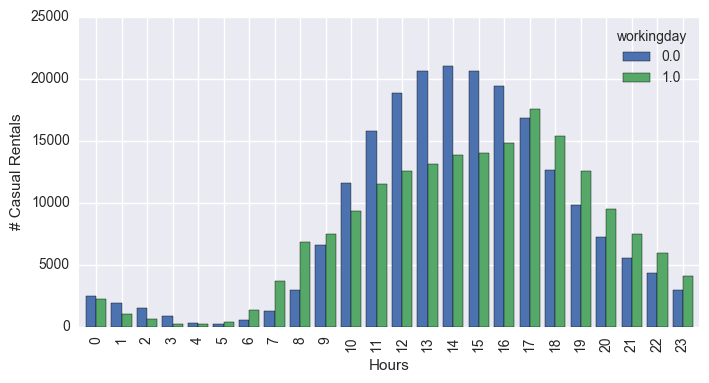

In [32]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['casual'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8, label='rush hours');
plt.ylabel('# Casual Rentals')
plt.xlabel('Hours')

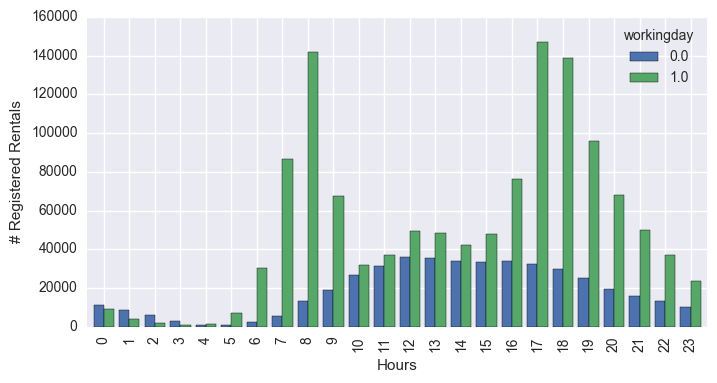

In [33]:
# rentals by hour, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['hour', 'workingday'])['registered'].agg('sum').unstack()

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Registered Rentals')
plt.xlabel('Hours')

In [35]:
## Add Rush Hours according to histograms
df_complete['rush_hour_casual_man'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  7 <= x['hour'] <= 23)
        or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

df_complete['rush_hour_reg_man'] = df_complete[['hour', 'workingday']].apply(
    lambda x: (0, 1)[
        (x['workingday'] == 1 and  (6 <= x['hour'] <= 9 or 16 <= x['hour'] <= 23))
        or (x['workingday'] == 0 and  8 <= x['hour'] <= 23)], axis = 1)

In [40]:
# Getting rules for hour rushes
hour_dt = tree.DecisionTreeRegressor(max_depth=2)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_hour = df_complete[df_complete['dataset'] == 'train']['hour']

hour_dt.fit(dt_hour[:, None], dt_casual)
print 'Casual Temp:'
print tree_to_code(hour_dt, ['hour'])


hour_dt.fit(dt_hour[:, None], dt_registered)
print 'Registered Temp:'
print tree_to_code(hour_dt, ['hour'])

Casual Temp:
def sk_tree(hour):
  if hour <= 9.5:
    if hour <= 7.5:
      return [[ 5.29744018]]
    else:  # if hour > 7.5
      return [[ 26.24945055]]
  else:  # if hour > 9.5
    if hour <= 19.5:
      return [[ 66.27336551]]
    else:  # if hour > 19.5
      return [[ 25.84155702]]
None
Registered Temp:
def sk_tree(hour):
  if hour <= 6.5:
    if hour <= 5.5:
      return [[ 20.63785395]]
    else:  # if hour > 5.5
      return [[ 72.10989011]]
  else:  # if hour > 6.5
    if hour <= 20.5:
      return [[ 228.05141872]]
    else:  # if hour > 20.5
      return [[ 109.94078947]]
None


In [42]:
# Functions for defining the rush hours
def rush_hour_casual_bucket(hour):
  if hour <= 9.5:
    if hour <= 7.5:
      return 1
    else:  # if hour > 7.5
      return 2
  else:  # if hour > 9.5
    if hour <= 19.5:
      return 3
    else:  # if hour > 19.5
      return 4

def rush_hour_reg_bucket(hour):
  if hour <= 6.5:
    if hour <= 5.5:
      return 1
    else:  # if hour > 5.5
      return 2
  else:  # if hour > 6.5
    if hour <= 20.5:
      return 3
    else:  # if hour > 20.5
      return 4

In [45]:
df_complete['rush_hour_casual_aut'] = df_complete['hour'].apply(lambda x: rush_hour_casual_bucket(x))
df_complete['rush_hour_reg_aut'] = df_complete['hour'].apply(lambda x: rush_hour_reg_bucket(x))

### Rush Temperature

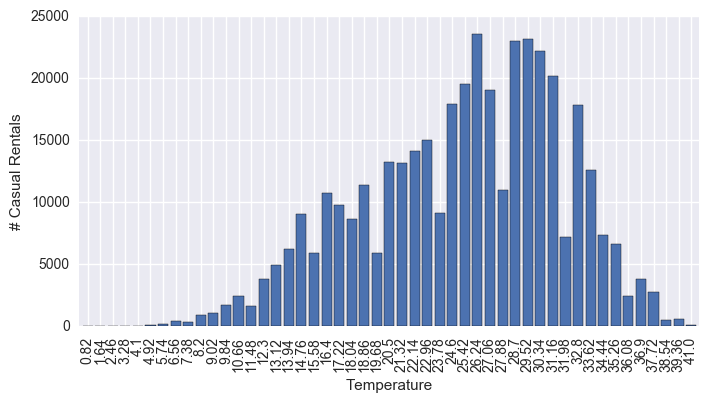

In [47]:
# casual rentals by temperature, split by working day (or not)
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['temp'])['casual'].agg('sum')

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Casual Rentals')
plt.xlabel('Temperature')

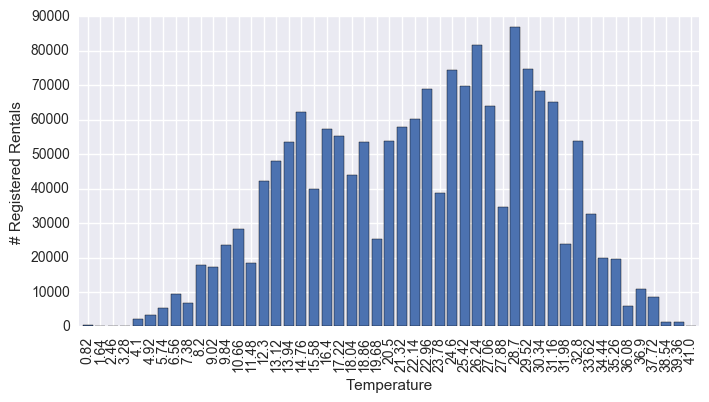

In [48]:
# registered rentals by temperature 
by_hour = df_complete[df_complete['dataset'] == 'train'].copy().groupby(['temp'])['registered'].agg('sum')

by_hour.plot(kind='bar', figsize=(8,4), width=0.8);
plt.ylabel('# Registered Rentals')
plt.xlabel('Temperature')

In [21]:
#Add rush temps:
df_complete['casual_rush_temp'] = df_complete[['temp']].apply(
    lambda x: (0, 1)[
        (20 <= x['temp'] <= 23)
        or (24 <= x['temp'] <= 27.2)
        or (28.5 <= x['temp'] <= 31.3)
        or (32.5 <= x['temp'] <= 34)], axis = 1)
df_complete['registered_rush_temp'] = df_complete[['temp']].apply(
    lambda x: (0, 1)[
        (12 <= x['temp'] <= 15)
        or (16 <= x['temp'] <= 19)
        or (20 <= x['temp'] <= 23)
        or (24.5 <= x['temp'] <= 27.1)
        or (28.5 <= x['temp'] <= 31.2)
        or (32 <= x['temp'] <= 33)], axis = 1)

In [ ]:
# Getting rules for temp rushes
temp_dt = tree.DecisionTreeRegressor(max_depth=3)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_temp = df_complete[df_complete['dataset'] == 'train']['temp']

temp_dt.fit(dt_temp[:, None], dt_casual)
print 'Casual Temp:'
print tree_to_code(temp_dt, ['temp'])


temp_dt.fit(dt_temp[:, None], dt_registered)
print 'Registered Temp:'
print tree_to_code(temp_dt, ['temp'])

In [22]:
# Functions for defining the temp rushes
def temp_rush_casual_bucket(temp):
  if temp <= 23.3699989319:
    if temp <= 15.1700000763:
      if temp <= 12.7100000381:
        return 1
      else:  # if temp > 12.7100000381
        return 2
    else:  # if temp > 15.1700000763
      if temp <= 19.2700004578:
        return 3
      else:  # if temp > 19.2700004578
        return 4
  else:  # if temp > 23.3699989319
    if temp <= 29.9300003052:
      if temp <= 29.1100006104:
        return 5
      else:  # if temp > 29.1100006104
        return 6
    else:  # if temp > 29.9300003052
      if temp <= 32.3899993896:
        return 7
      else:  # if temp > 32.3899993896
        return 8

def temp_rush_registered_bucket(temp):
  if temp <= 22.5499992371:
    if temp <= 12.7100000381:
      if temp <= 11.0699996948:
        return 1
      else:  # if temp > 11.0699996948
        return 2
    else:  # if temp > 12.7100000381
      if temp <= 19.2700004578:
        return 3
      else:  # if temp > 19.2700004578
        return 4
  else:  # if temp > 22.5499992371
    if temp <= 29.9300003052:
      if temp <= 28.2900009155:
        return 5
      else:  # if temp > 28.2900009155
        return 6
    else:  # if temp > 29.9300003052
      if temp <= 30.75:
        return 7
      else:  # if temp > 30.75
        return 8


In [23]:
df_complete['casual_rush_temp_2'] = df_complete['temp'].apply(lambda x: temp_rush_casual_bucket(x))
df_complete['registered_rush_temp_2'] = df_complete['temp'].apply(lambda x: temp_rush_registered_bucket(x))

In [ ]:
# Getting rules for humidity rushes
humidity_dt = tree.DecisionTreeRegressor(max_depth=2)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_humidity = df_complete[df_complete['dataset'] == 'train']['humidity']

humidity_dt.fit(dt_humidity[:, None], dt_casual)
print 'Casual Temp:'
print tree_to_code(humidity_dt, ['humidity'])

humidity_dt.fit(dt_humidity[:, None], dt_registered)
print 'Registered Temp:'
print tree_to_code(humidity_dt, ['humidity'])

In [24]:
# Functions for defining the humidity rushes
def humidity_rush_casual_bucket(humidity):
  if humidity <= 55.5:
    if humidity <= 39.5:
      return 1
    else:  # if humidity > 39.5
      return 2
  else:  # if humidity > 55.5
    if humidity <= 74.5:
      return 3
    else:  # if humidity > 74.5
      return 4

def humidity_rush_registered_bucket(humidity):
  if humidity <= 66.5:
    if humidity <= 43.5:
      return 1
    else:  # if humidity > 43.5
      return 2
  else:  # if humidity > 66.5
    if humidity <= 84.5:
      return 3
    else:  # if humidity > 84.5
      return 4

In [25]:
df_complete['casual_rush_humidity_2'] = df_complete['humidity'].apply(lambda x: humidity_rush_casual_bucket(x))
df_complete['registered_rush_humidity_2'] = df_complete['humidity'].apply(lambda x: humidity_rush_registered_bucket(x))

In [ ]:
# Getting rules for wind/humidity rushes
wind_dt = tree.DecisionTreeRegressor(max_depth=2)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_wind = df_complete[df_complete['dataset'] == 'train']['windspeed']

wind_dt.fit(dt_wind[:, None], dt_casual)
print 'Casual Wind:'
print tree_to_code(wind_dt, ['windspeed'])

wind_dt.fit(dt_wind[:, None], dt_registered)
print 'Registered Wind:'
print tree_to_code(wind_dt, ['windspeed'])

In [ ]:
def wind_rush_registered_bucket(windspeed):
  if windspeed <= 9.99975013733:
    if windspeed <= 7.99980020523:
      return 1
    else:  # if windspeed > 7.99980020523
      return 2
  else:  # if windspeed > 9.99975013733
    if windspeed <= 15.9995994568:
      return 3
    else:  # if windspeed > 15.9995994568
      return 4

def wind_rush_registered_bucket(windspeed):
  if windspeed <= 9.99975013733:
    if windspeed <= 6.50234985352:
      return 1
    else:  # if windspeed > 6.50234985352
      return 2
  else:  # if windspeed > 9.99975013733
    if windspeed <= 41.9989471436:
      return 3
    else:  # if windspeed > 41.9989471436
      return 4

In [ ]:
df_complete['casual_rush_wind_2'] = df_complete['windspeed'].apply(lambda x: wind_rush_registered_bucket(x))
df_complete['registered_rush_wind_2'] = df_complete['windspeed'].apply(lambda x: wind_rush_registered_bucket(x))

In [26]:
## Add feature that indicates if it's raining or not
df_complete['rain'] = ((df_complete['weather'] == 3) | (df_complete['weather'] == 4)).astype(int)
#del df_complete['weather']

In [ ]:
## add quarters by year
df_complete['year_quarter'] = 1

df_complete.loc[(1 <= df_complete.index.month)
                & (df_complete.index.month <= 3),
                'year_quarter'] = 1
df_complete.loc[(4 <= df_complete.index.month) 
                & (df_complete.index.month <= 6)
                , 'year_quarter'] = 2
df_complete.loc[(7 <= df_complete.index.month) 
                & (df_complete.index.month <= 9)
                , 'year_quarter'] = 3
df_complete.loc[(10 <= df_complete.index.month) 
                & (df_complete.index.month <= 12)
                , 'year_quarter'] = 4


In [27]:
df_complete.head(n=2)

,casual,registered,log_casual,log_registered,dataset,atemp,humidity,temp,windspeed,weather,...,weekend,casual_rush,registered_rush,casual_rush_temp,registered_rush_temp,casual_rush_temp_2,registered_rush_temp_2,casual_rush_humidity_2,registered_rush_humidity_2,rain
2011-01-01 00:00:00,3.0,13.0,1.386294,2.639057,train,14.395,81.0,9.84,0.0,1.0,...,1,0,0,0,0,1,1,4,3,0
2011-01-01 01:00:00,8.0,32.0,2.197225,3.496508,train,13.635,80.0,9.02,0.0,1.0,...,1,0,0,0,0,1,1,4,3,0


In [ ]:
#df_complete['ideal'] = df_complete[['temp', 'windspeed']].apply(lambda x: (0, 1)[x['temp'] > 27 and x['windspeed'] < 30], axis = 1)
#df_complete['sticky'] = df_complete[['humidity', 'workingday']].apply(lambda x: (0, 1)[x['workingday'] == 1 and x['humidity'] >= 60], axis = 1)

In [28]:
## Adding some missed "holydays"

# tax day
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "workingday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "workingday"] = 1

# thanksgiving friday
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "workingday"] = 0

# tax day
df_complete.loc[get_day_range(pd.datetime(2011, 4, 15)), "holiday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
df_complete.loc[get_day_range(pd.datetime(2011, 11, 25)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 11, 23)), "holiday"] = 1

#pre christmas / new year
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 24)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 24)), "workingday"] = 0

df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "holiday"] = 1
df_complete.loc[get_day_range(pd.datetime(2011, 12, 31)), "workingday"] = 0
df_complete.loc[get_day_range(pd.datetime(2012, 12, 31)), "workingday"] = 0



In [ ]:
# Getting rules for hour buckets
hours_dt = tree.DecisionTreeRegressor(max_depth=2)

dt_casual = df_complete[df_complete['dataset'] == 'train']['casual']
dt_registered = df_complete[df_complete['dataset'] == 'train']['registered']
dt_hours = df_complete[df_complete['dataset'] == 'train']['hour']

hours_dt.fit(dt_hours[:, None], dt_casual)
print 'Casual Temp:'
print tree_to_code(hours_dt, ['hour'])

hours_dt.fit(dt_hours[:, None], dt_registered)
print 'Registered Temp:'
print tree_to_code(hours_dt, ['hour'])

In [30]:
def hour_casual_bucket(hour):
  if hour <= 9.5:
    if hour <= 7.5:
      return 1
    else:  # if hour > 7.5
      return 2
  else:  # if hour > 9.5
    if hour <= 19.5:
      return 3
    else:  # if hour > 19.5
      return 4

def hour_registered_bucket(hour):
  if hour <= 6.5:
    if hour <= 5.5:
      return 1
    else:  # if hour > 5.5
      return 2
  else:  # if hour > 6.5
    if hour <= 20.5:
      return 3
    else:  # if hour > 20.5
      return 4

In [31]:
df_complete['bck_hour_casual'] = df_complete['hour'].apply(lambda x: hour_casual_bucket(x))
df_complete['bck_hour_registered'] = df_complete['hour'].apply(lambda x: hour_registered_bucket(x))

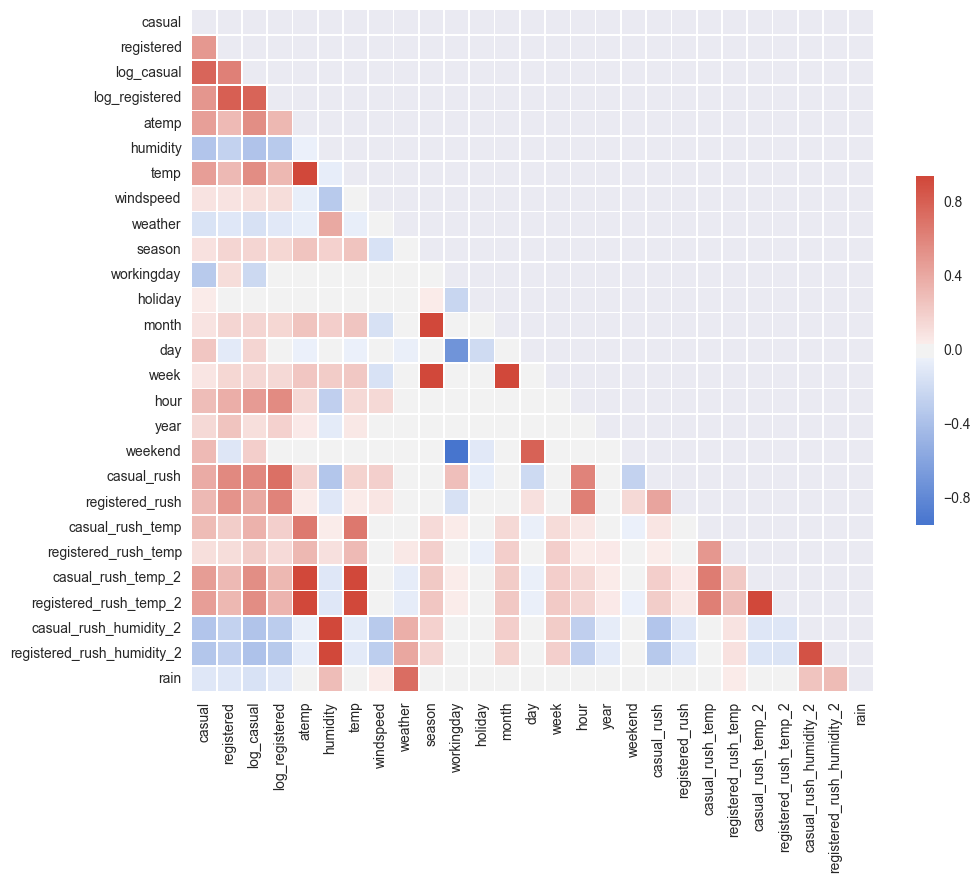

In [29]:

# Compute the correlation matrix
corr = df_complete[df_complete['dataset'] == 'train'].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(256, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Models

In [32]:
# FEATURES TO USE
# month reduces the accuracy considerable
# year_quarter also reduces accuracy
# week also reduces the accuracy
features_common = ['humidity', 'atemp', 'temp', 'windspeed', 'weather', 'rain', 'season', 'holiday',   
        'workingday', 'weekend', 'day', 'hour']


features_casual = features_common + ['rush_hour_casual_man', 'casual_rush_temp', 'casual_rush_temp_2',
                                     'casual_rush_humidity_2', 'bck_hour_casual']
features_registered = features_common + ['rush_hour_reg_man', 'registered_rush_temp', 'registered_rush_temp_2',
                                         'registered_rush_humidity_2']

## Contruct Training and Testing Sets

In [34]:
use_log = True

In [35]:
df_train = df_complete[df_complete['dataset'] == 'train']
del df_train['dataset']


df_train_y_c = df_train['log_casual'].values if use_log else df_train['casual'].values
df_train_y_r = df_train['log_registered'].values if use_log else df_train['registered'].values
df_train_y = df_train_y_c + df_train_y_r

df_train_x = df_train.drop(['casual', 'registered', 'log_casual', 'log_registered'],axis = 1)#.values
df_train_x_c = df_train_x[features_casual]
df_train_x_r = df_train_x[features_registered]

In [36]:
df_test = df_complete[df_complete['dataset'] == 'test']
del df_test['dataset']
#del df_test['count']
del df_test['casual']
del df_test['registered']

In [37]:
# Cross Validation Generator
cv = cross_validation.ShuffleSplit(len(df_train_x), n_iter=3, test_size=0.2,
    random_state=0)

## Decision Tree

In [ ]:
#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    {'max_depth':[9,10,11,20,25,50]},
    {'min_samples_leaf':[1,2,5,10,50,100]},
    {'min_samples_split':[1,2,5,10,50,100]},
    {'presort':[True, False]},
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}]   
    
scores = ['r2']

for score in scores:
    
    print score
    
    clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""

In [ ]:
# Cross Validation
dtr = tree.DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
for train, test in cv:
    clf = dtr.fit(df_train_x[train], df_train_y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf.score(df_train_x[train], df_train_y[train]), clf.score(df_train_x[test], df_train_y[test])))

In [ ]:
# Best Model
dtr = tree.DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [ ]:
# Predicting & Exporting File
dtr_pred = predictWithModel(dtr, df_train_x, df_train_y_c, df_train_y_r, df_test, features_casual, features_registered, use_log)
printPrediction(dtr_pred)

## Random Forest

In [ ]:
#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    {'max_depth':[50,100, 500, 1000]}, #Best: 1000
    #{'n_estimators':[1000, 10000]}, #We assume is 1000
    {'min_samples_leaf':[1,2,5,10,50,100]}, #2
    {'min_samples_split':[1,2,5,10,50,100]}, #10
    {'min_weight_fraction_leaf':[0.0, 0.1, 0.3, 0.4, 0.5]}] #0.0    
    
scores = ['r2']

for score in scores:
    
    print score
    
    clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(clf.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""


In [ ]:
print df_train_x.shape
print df_train_y.shape

In [ ]:
# Cross Validation
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

for train, test in cv:
    clf = rfr.fit(df_train_x.iloc[train], df_train_y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf.score(df_train_x.iloc[train], df_train_y[train]), clf.score(df_train_x.iloc[test], df_train_y[test])))

In [38]:
#Optimized model
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [ ]:
# Predicting Year by Year
rfr_pred = predictWithModel(rfr, df_train_x, df_train_y_c, df_train_y_r, df_test, features_casual, features_registered, use_log)
printPrediction(rfr_pred)

## XGBoost Regressor

In [ ]:
#xgb_model = xgb.XGBRegressor()
#clf = GridSearchCV(xgb_model,
#                   {'max_depth': [2,4,6],
#'n_estimators': [50,100,200]}, verbose=1)


#Finding best parameters
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    df_train_x, df_train_y, test_size=0.3, random_state=0)

tuned_parameters = [
    #{'max_depth': [2,5,10,100,1000,5000,10000]}, # best 100
    #{'n_estimators': [50,100,500,1000,5000,10000]}, # best 5000
    {'learning_rate': [0.15, 0.18, 0.2, 0.29, 0.3]}]  #best 0.2
    
scores = ['r2']

for score in scores:
    
    print score
    
    xgbr = GridSearchCV(xgb.XGBRegressor(), tuned_parameters, cv=5, scoring=score)
    xgbr.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    
    #best_estimator_ returns the best estimator chosen by the search
    print(xgbr.best_estimator_)
    print ""
    print("Grid scores on development set:")
    print ""
    #grid_scores_ returns:
    #    * a dict of parameter settings
    #    * the mean score over the cross-validation folds 
    #    * the list of scores for each fold
    for params, mean_score, scores in xgbr.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print ""


In [ ]:
# Cross Validation
xgbr = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=1000,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

for train, test in cv:
    clf_c = xgbr.fit(df_train_x_c.iloc[train], df_train_y_c[train])
    print("Casual: train score: {0:.3f}, test score: {1:.3f}".format(
        clf_c.score(df_train_x_c.iloc[train], df_train_y_c[train]), clf_c.score(df_train_x_c.iloc[test], df_train_y_c[test])))
    clf_r = xgbr.fit(df_train_x_r.iloc[train], df_train_y_r[train])
    print("Regist: train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf_r.score(df_train_x_r.iloc[train], df_train_y_r[train]), clf_r.score(df_train_x_r.iloc[test], df_train_y_r[test])))

In [39]:
#Optimized model
xgbr = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=1000,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [ ]:
# Predicting Year by Year
xgbr_pred = predictWithModel(xgbr, df_train_x, df_train_y_c, df_train_y_r, df_test, features_casual, features_registered, use_log)
printPrediction(xgbr_pred)

## Merging models

In [ ]:
rfr_dtr_merged_pred = 0.9 * rfr_pred + 0.1 * xgbr_pred
printPrediction(rfr_dtr_merged_pred)

In [ ]:
rfr_xgbr_merged_pred = 0.55 * rfr_pred + 0.45 * xgbr_pred
printPrediction(rfr_xgbr_merged_pred)

# Quick Run

In [40]:
features_common = ['humidity', 'atemp', 'temp', 'windspeed', 'weather', 'rain', 'season', 'holiday',   
        'workingday', 'weekend', 'day', 'hour']

features_casual = features_common + ['rush_hour_casual_man', 'casual_rush_temp', 'casual_rush_temp_2',
                                     'casual_rush_humidity_2', 'bck_hour_casual']
features_registered = features_common + ['rush_hour_reg_man', 'registered_rush_temp', 'registered_rush_temp_2',
                                         'registered_rush_humidity_2']

In [ ]:
use_log = True

df_train = df_complete[df_complete['dataset'] == 'train']
del df_train['dataset']


df_train_y_c = df_train['log_casual'].values if use_log else df_train['casual'].values
df_train_y_r = df_train['log_registered'].values if use_log else df_train['registered'].values
df_train_y = df_train_y_c + df_train_y_r

df_train_x = df_train.drop(['casual', 'registered', 'log_casual', 'log_registered'],axis = 1)#.values
df_train_x_c = df_train_x[features_casual]
df_train_x_r = df_train_x[features_registered]

df_test = df_complete[df_complete['dataset'] == 'test']
del df_test['dataset']
#del df_test['count']
del df_test['casual']
del df_test['registered']

In [ ]:
# Cross Validation
cv = cross_validation.ShuffleSplit(len(df_train_x), n_iter=1, test_size=0.2, random_state=0)

xgbr = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.2, max_delta_step=0, max_depth=1000,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=1000,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

for train, test in cv:
    clf_c = xgbr.fit(df_train_x_c.iloc[train], df_train_y_c[train])
    print("XGB Casual: train score: {0:.3f}, test score: {1:.3f}".format(
        clf_c.score(df_train_x_c.iloc[train], df_train_y_c[train]), clf_c.score(df_train_x_c.iloc[test], df_train_y_c[test])))
    clf_r = xgbr.fit(df_train_x_r.iloc[train], df_train_y_r[train])
    print("XGB Regist: train score: {0:.3f}, test score: {1:.3f}".format(
        clf_r.score(df_train_x_r.iloc[train], df_train_y_r[train]), clf_r.score(df_train_x_r.iloc[test], df_train_y_r[test])))
    clf_c = rfr.fit(df_train_x_c.iloc[train], df_train_y_c[train])
    print("RF  Casual: train score: {0:.3f}, test score: {1:.3f}".format(
        clf_c.score(df_train_x_c.iloc[train], df_train_y_c[train]), clf_c.score(df_train_x_c.iloc[test], df_train_y_c[test])))
    clf_r = rfr.fit(df_train_x_r.iloc[train], df_train_y_r[train])
    print("RF  Regist: train score: {0:.3f}, test score: {1:.3f}\n".format(
        clf_r.score(df_train_x_r.iloc[train], df_train_y_r[train]), clf_r.score(df_train_x_r.iloc[test], df_train_y_r[test])))

In [41]:
rfr_pred = predictWithModel(rfr, df_train_x, df_train_y_c, df_train_y_r, df_test, features_casual, features_registered, use_log)
xgbr_pred = predictWithModel(xgbr, df_train_x, df_train_y_c, df_train_y_r, df_test, features_casual, features_registered, use_log)

Predicting: 2011
Predicting: 2012
Predicting: 2011
Predicting: 2012


In [ ]:
rfr_xgbr_merged_pred = 0.48 * rfr_pred + 0.42 * xgbr_pred
printPrediction(rfr_xgbr_merged_pred)

In [42]:
rfr_xgbr_merged_pred = 0.73 * rfr_pred + 0.27 * xgbr_pred
printPrediction(rfr_xgbr_merged_pred)

In [ ]:
#saving this just in case
features_common = ['humidity', 'atemp', 'temp', 'windspeed', 'weather', 'rain', 'season', 'holiday',   
        'workingday', 'weekend', 'day', 'hour']


features_casual = features_common + ['rush_hour_casual_man', 'casual_rush_temp', 'casual_rush_temp_2',
                                     'casual_rush_humidity_2', 'bck_hour_casual']
features_registered = features_common + ['rush_hour_reg_man', 'registered_rush_temp', 'registered_rush_temp_2',
                                         'registered_rush_humidity_2']